In [2]:
import os
import cv2
import torch 
import numpy as np
import pandas as pd
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
from torchvision import transforms
from PIL import Image
from torchnlp.encoders import LabelEncoder
import tensorflow as tf
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import glob
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import pad

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
videos = glob.glob('data/s1/*.mpg')
alignment = glob.glob('data/alignments/s1/*.align')
video_names = []
alignment_names = []
for i in videos:
    i = i.replace("\\", "/")
    video_names.append(i)
for x in alignment:
    x = x.replace("mpg", "align")
    x = x.replace("\\", "/")
    alignment_names.append(x)
    

data = {'video_name': video_names, 'alignment_names': alignment_names}

data = pd.DataFrame(data)

In [5]:
def load_video(path:str): 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame[ :, :, None]
        frame = frame[190:236,80:220,:]
        #frame = torch.tensor(frame, dtype=torch.float32)
        #frame = frame.permute(2,0,1)
        frames.append(frame)
        
    cap.release()
    frames = torch.tensor(frames, dtype=torch.float32)/255
    frames = frames.permute(3,0,1,2)
    #frames = frames[:,:,:,:]
    return frames


C:\Users\KASHYAP\AppData\Local\Temp\ipykernel_10316\3827501606.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  frames = torch.tensor(frames, dtype=torch.float32)/255


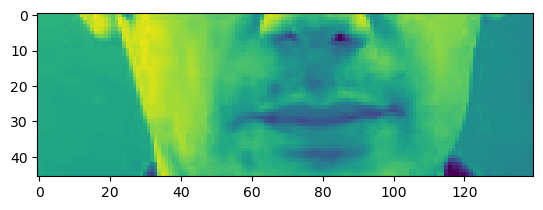

In [6]:
frames = load_video('data/s1/bbaf2n.mpg')
img = frames.permute(1,0,2,3)
plt.imshow(img[1].permute(1,2,0))

In [7]:
char = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
encoder = LabelEncoder(char, reserved_labels=['unknown'], unknown_index=0)
encoder.batch_encode(['f', 't']), encoder.batch_decode(torch.tensor([5, 6, 9]))
len(char)

39

In [8]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens, ' ', list(line[2])]
    flat_list = [item for sublist in tokens for item in sublist]
    
    encoded = encoder.batch_encode(flat_list)[1:]
    return  torch.nn.ConstantPad1d((0, 30 - encoded.shape[0]), 0)(encoded)

In [9]:
load_alignments(path='data/alignments/s1/bbaf2n.align')


tensor([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15, 39,
        14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [10]:
def load_data(video_path:str, alignment_path:str):

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)


    return frames, alignments

In [11]:
frames, alignments = load_data(data.iloc[0,0], data.iloc[0,1])
frames.shape, alignments

(torch.Size([1, 75, 46, 140]),
 tensor([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15, 39,
         14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

bin blue at f two nowunknownunknownunknownunknownunknownunknownunknownunknownunknown


(<matplotlib.image.AxesImage at 0x1ccd9fbe280>,
 torch.Size([1, 75, 46, 140]),
 None)

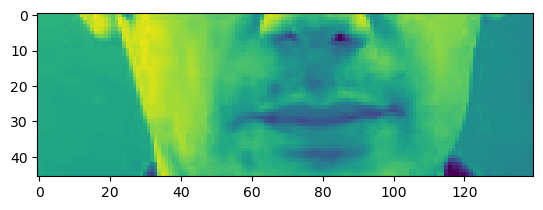

In [12]:
plt.imshow((frames.permute(1,2,3,0))[1]), frames.shape, print(''.join(encoder.batch_decode(alignments)))   

In [13]:
class custom_dataset(Dataset):
    def __init__(self, data) -> None:
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        video_path = self.data.iloc[idx, 0]
        alignment_path = self.data.iloc[idx, 1]
        frames, alignments = load_data(video_path,alignment_path)
        #frames = frames[:,75,:,:]
        #packed_seq_batch = torch.nn.utils.rnn.pack_padded_sequence(alignments, lengths=[40], batch_first=True)

        return frames, alignments
        

In [14]:
train_data = custom_dataset(data)
data_loaded = DataLoader(train_data, batch_size=1,shuffle=True)

In [15]:
frame, alignment = next(iter(data_loaded))
frame.shape, alignment.shape

(torch.Size([1, 1, 75, 46, 140]), torch.Size([1, 30]))

In [16]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0),-1,y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [17]:
class LipNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv3d_layer1 = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2))
        )
        self.conv3d_layer2 = nn.Sequential(
            nn.Conv3d(in_channels=128, out_channels=256, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2))
        )
        self.conv3d_layer3 = nn.Sequential(
            nn.Conv3d(in_channels=256, out_channels=75, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2))
        )
        self.TimeDistributed  = TimeDistributed(nn.Flatten())
        self.LSTM1 = nn.LSTM(input_size = 6375, hidden_size = 128,num_layers=2,bidirectional=True, dropout=0.5, batch_first=True) 
        self.Linear = nn.Linear(in_features=256, out_features=40)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):

        x = self.conv3d_layer3(self.conv3d_layer2(self.conv3d_layer1(x))).permute(0,1,3,4,2)
        x = self.TimeDistributed(x).permute(0,2,1)
        x, (i, j) = self.LSTM1(x)
        x = self.softmax(self.Linear(x))

        return x
        

torch.manual_seed(42) 
model_0 = LipNet().to(device)
print(model_0)

LipNet(
  (conv3d_layer1): Sequential(
    (0): Conv3d(1, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3d_layer2): Sequential(
    (0): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3d_layer3): Sequential(
    (0): Conv3d(256, 75, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (TimeDistributed): TimeDistributed(
    (module): Flatten(start_dim=1, end_dim=-1)
  )
  (LSTM1): LSTM(6375, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (Linear): Linear(in_features=256, out_features=40, bias=True)
  (softmax): Softmax(dim=1)
)


In [18]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=frame.shape)

Layer (type:depth-idx)                   Output Shape              Param #
LipNet                                   [1, 75, 40]               --
├─Sequential: 1-1                        [1, 128, 75, 23, 70]      --
│    └─Conv3d: 2-1                       [1, 128, 75, 46, 140]     256
│    └─ReLU: 2-2                         [1, 128, 75, 46, 140]     --
│    └─MaxPool3d: 2-3                    [1, 128, 75, 23, 70]      --
├─Sequential: 1-2                        [1, 256, 75, 11, 35]      --
│    └─Conv3d: 2-4                       [1, 256, 75, 23, 70]      33,024
│    └─ReLU: 2-5                         [1, 256, 75, 23, 70]      --
│    └─MaxPool3d: 2-6                    [1, 256, 75, 11, 35]      --
├─Sequential: 1-3                        [1, 75, 75, 5, 17]        --
│    └─Conv3d: 2-7                       [1, 75, 75, 11, 35]       19,275
│    └─ReLU: 2-8                         [1, 75, 75, 11, 35]       --
│    └─MaxPool3d: 2-9                    [1, 75, 75, 5, 17]        --
├─Time

In [19]:
model_0.eval()
with torch.inference_mode():
    pred = model_0(frame.to(device)).to(device)

In [20]:
pred.shape, alignment.shape#, encoder.batch_decode(torch.argmax(pred[0],dim=1))

(torch.Size([1, 75, 40]), torch.Size([1, 30]))

In [21]:
def CtcLoss(y, y_pred):
    input_length = torch.full(size=(y.shape[0],), fill_value=1, dtype=torch.long)
    target_length = torch.full(size=(y_pred.shape[0],), fill_value=1, dtype=torch.long)
    ctc_loss = nn.CTCLoss()
    loss = ctc_loss(y_pred.permute(1,0,2), y, input_length, target_length)
    return loss

In [22]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss = 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y, y_pred)
        #train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    
        
    train_loss = loss / len(dataloader)
    
    return train_loss, y, y_pred
        

In [30]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss = 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            model = model.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y, test_pred_logits)
            
            
            
            
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = loss / len(dataloader)
    
    return test_loss, y, test_pred_logits

In [27]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 100):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "test_loss": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, y, y_pred = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                          optimizer=optimizer)
        



        '''if epoch % 5 == 0:
            print(' '.join(encoder.batch_decode(y[0])), end='\n')
        #print(torch.argmax(y_pred[0],dim=1))
            print(''.join(encoder.batch_decode(torch.argmax(y_pred[0],dim=1))), end='\n')
        
      
        test_loss, y, test_pred_logits = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)'''
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1}\n"
            f"train_loss: {train_loss} | " 
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        #results["test_loss"].append(test_loss)

    # 6. Return the filled results at the end of the epochs

    return results

In [28]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * np.exp(-0.1)

In [29]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Recreate an instance of TinyVGG
model = LipNet().to(device)

# Setup loss function and optimizer
loss_fn = CtcLoss
optimizer = torch.optim.Adam(params=model.parameters(), lr=scheduler(epochs, 0.1))

# Start the timer
from timeit import default_timer as timer 
start_time = timer()
model_0_results = train(model=model, 
                        train_dataloader=data_loaded,
                        test_dataloader=data_loaded,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=epochs)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  1%|          | 1/100 [22:55<37:49:38, 1375.54s/it]

Epoch: 1
train_loss: -2.196228631899319e-13 | 


  2%|▏         | 2/100 [45:42<37:18:25, 1370.47s/it]

Epoch: 2
train_loss: -2.8925836335555455e-14 | 


  2%|▏         | 2/100 [1:06:31<54:19:32, 1995.64s/it]


KeyboardInterrupt: 